In [111]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk
import json

In [18]:
train_json_data = json.load(open('train.json'))
train_df = pandas.json_normalize(train_json_data)

test_json_data = json.load(open('test.json'))
test_df = pandas.json_normalize(test_json_data)

In [54]:
train_df.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

## giver_username_if_known
Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

Notes:

There are 3753 N/A values. There are 250 unique values. 225 values only appear once. 1 username appears 5 times, 2 usernames appear 4 times, 3 usernames appear 3 times, and 2 usernames appear 16 times.
N/A usernames contains those who received pizza and those who did not. So N/A is not an indicator of whether the post did not get a pizza.

In [132]:
# number of unique values
# number of most frequently appearing username (which is N/A)
train_df.giver_username_if_known.describe()

count     4040
unique     250
top        N/A
freq      3753
Name: giver_username_if_known, dtype: object

In [145]:
# number of giver usernames that only show up once
giver_username_counts = train_df.giver_username_if_known.value_counts()
giver_username_counts[giver_username_counts == 1].shape

(225,)

In [141]:
# look at usernames that show up more than 1 time
giver_username_counts[giver_username_counts > 1]

N/A                     3753
jetboyterp                 5
m2nu                       4
johngalt1337               4
thr                        4
mr_jeep                    4
glinda_da_good_witch       3
pizzamom                   3
leftnewdigg                3
bgoodrbcareful             2
pastafariantwit            2
dezmodez                   2
boatdude                   2
idtugyourboat              2
kramapple                  2
harrisonfire               2
zandyman                   2
olivertw1st                2
psm321                     2
ladyjanegr                 2
govalle                    2
foki                       2
whosthatguru_v2            2
fogdelune                  2
jabberworx                 2
Name: giver_username_if_known, dtype: int64

In [128]:
# how many requests got a pizza with a giver who's user_name is N/A
train_df.requester_received_pizza[train_df.giver_username_if_known == 'N/A'].value_counts()

False    3046
True      707
Name: requester_received_pizza, dtype: int64

## number_of_downvotes_of_request_at_retrieval
Number of downvotes at the time the request was collected.

Notes: 

Number of downvotes ranges from 0 to 47. There are 811 requests that have 0 downvotes. There is only 1 request that has 47 downvotes (must've been a unique request that people didn't like; double checked and the request didn't get a pizza). The most frequent number of downvotes a request gets is 1 (why?).

The average downvotes a request has is 2.4. The median downvotes are 2. This indicates that the number of downvotes are skewed to the lower end (right skewed).

25% of people who receive downvotes got a pizza. Simiarly, 24% of people who don't receive downvotes got a pizza. Will need to see if there's another wa to determine if downvotes have a connection to getting a pizza.

In [169]:
print(train_df.number_of_downvotes_of_request_at_retrieval.describe())
# print(train_df.number_of_downvotes_of_request_at_retrieval.value_counts())
print(train_df.number_of_downvotes_of_request_at_retrieval.value_counts()[:5])
print(train_df.number_of_downvotes_of_request_at_retrieval.value_counts()[-5:])


count    4040.000000
mean        2.424505
std         3.023101
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        47.000000
Name: number_of_downvotes_of_request_at_retrieval, dtype: float64
1    1059
0     811
2     807
3     512
4     301
Name: number_of_downvotes_of_request_at_retrieval, dtype: int64
28    1
23    1
29    1
35    1
47    1
Name: number_of_downvotes_of_request_at_retrieval, dtype: int64


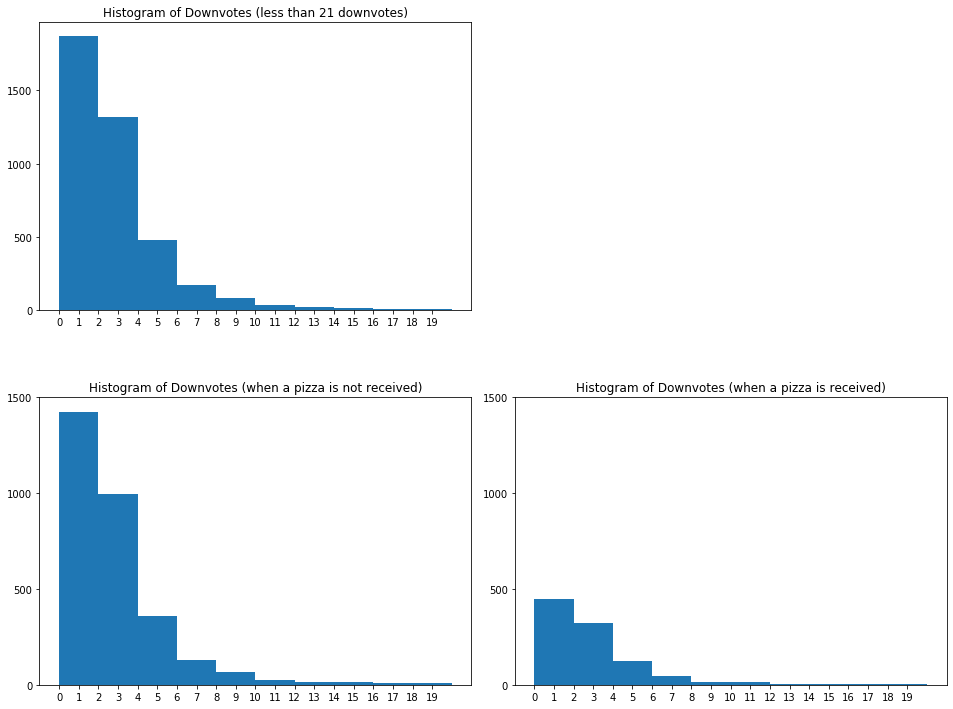

In [240]:
# plotting distribution of downvotes
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.number_of_downvotes_of_request_at_retrieval[train_df.number_of_downvotes_of_request_at_retrieval < 21])
axes1.set_title("Histogram of Downvotes (less than 21 downvotes)")
axes1.set_yticks(range(0,2000, 500))
axes1.set_xticks(range(0,20, 1))

# plotting distribution of downvotes when someone received a pizza
axes2.hist(train_df.number_of_downvotes_of_request_at_retrieval[(train_df.requester_received_pizza == 1) & (train_df.number_of_downvotes_of_request_at_retrieval < 21)])
axes2.set_title("Histogram of Downvotes (when a pizza is received)")
axes2.set_yticks(range(0,2000, 500))
axes2.set_xticks(range(0,20, 1))

# plotting distribution of downvotes when someone did not receive a pizza
axes3.hist(train_df.number_of_downvotes_of_request_at_retrieval[(train_df.requester_received_pizza == 0) & (train_df.number_of_downvotes_of_request_at_retrieval < 21)])
axes3.set_title("Histogram of Downvotes (when a pizza is not received)")
axes3.set_yticks(range(0,2000, 500))
axes3.set_xticks(range(0,20, 1))

In [125]:
# seeing number of requestors by whether they got a pizza and number of downvotes
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.number_of_downvotes_of_request_at_retrieval, 10)) 

number_of_downvotes_of_request_at_retrieval,"(-0.047, 4.7]","(4.7, 9.4]","(9.4, 14.1]","(14.1, 18.8]","(18.8, 23.5]","(23.5, 28.2]","(28.2, 32.9]","(32.9, 37.6]","(42.3, 47.0]"
requester_received_pizza,,,,,,,,,
False,2646,324,47,14,11,1,2,0,1
True,844,116,22,5,2,1,2,2,0


In [119]:
# now using buckets downvotes (threshold of at least 1 downvote)
train_df['downvotes_bucketed'] = np.where(train_df.number_of_downvotes_of_request_at_retrieval >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.downvotes_bucketed) 

downvotes_bucketed,0,1
requester_received_pizza,,
False,619,2427
True,192,802


In [154]:
# now using buckets downvotes (threshold of at least 2 downvotes; since 0 and 1 are the most frequent)
train_df['downvotes_bucketed'] = np.where(train_df.number_of_downvotes_of_request_at_retrieval >= 2, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.downvotes_bucketed) 

downvotes_bucketed,0,1
requester_received_pizza,,
False,1422,1624
True,448,546


## number_of_upvotes_of_request_at_retrieval
Number of upvotes at the time the request was collected.

Notes:
Number of upvotes ranges from 0 to 345 (a lot higher than downvotes). There are 12 requests that have 0 upvotes indicating that most requests get an upvote. There is only 1 request that has 345 upvotes (must've been a unique request that people really liked). The most frequent number of upvotes is 2 (higher than most frequent umber of downvotes). The average downvotes a request has is 6.2. The median downvotes are 4 (double median of downvotes). This indicates that the number of upvotes are skewed to the lower end (right skewed).

People tend to get more upvotes than down votes.

25% of people who receive upvotes got a pizza. While 20% of people who don't receive upvotes got a pizza (remember the low n-count though). Will need to see if net votes (combination of upvotes and downvotes) is a getter indicator.

In [177]:
print(train_df.number_of_upvotes_of_request_at_retrieval.describe())
# print(train_df.number_of_upvotes_of_request_at_retrieval.value_counts())
print(train_df.number_of_upvotes_of_request_at_retrieval.value_counts()[:5])
print(train_df.number_of_upvotes_of_request_at_retrieval.value_counts()[-5:])


count    4040.000000
mean        6.180446
std        10.746320
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       345.000000
Name: number_of_upvotes_of_request_at_retrieval, dtype: float64
2    709
3    639
4    516
1    455
5    341
Name: number_of_upvotes_of_request_at_retrieval, dtype: int64
76     1
72     1
70     1
64     1
222    1
Name: number_of_upvotes_of_request_at_retrieval, dtype: int64


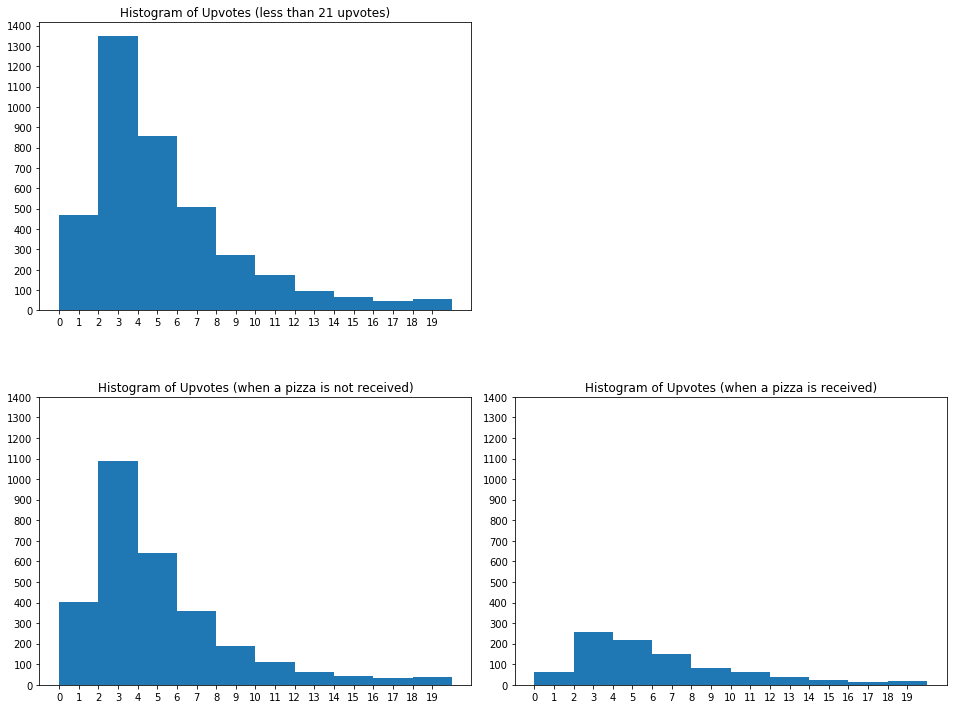

In [241]:
# plotting distribution of downvotes
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.number_of_upvotes_of_request_at_retrieval[train_df.number_of_upvotes_of_request_at_retrieval <21])
axes1.set_title("Histogram of Upvotes (less than 21 upvotes)")
axes1.set_yticks(range(0,1500, 100))
axes1.set_xticks(range(0,20, 1))

# plotting distribution of downvotes when someone received a pizza
axes2.hist(train_df.number_of_upvotes_of_request_at_retrieval[(train_df.requester_received_pizza == 1) & (train_df.number_of_upvotes_of_request_at_retrieval <21)])
axes2.set_title("Histogram of Upvotes (when a pizza is received)")
axes2.set_yticks(range(0,1500, 100))
axes2.set_xticks(range(0,20, 1))

# plotting distribution of downvotes when someone did not receive a pizza
axes3.hist(train_df.number_of_upvotes_of_request_at_retrieval[(train_df.requester_received_pizza == 0) & (train_df.number_of_upvotes_of_request_at_retrieval <21)])
axes3.set_title("Histogram of Upvotes (when a pizza is not received)")
axes3.set_yticks(range(0,1500, 100))
axes3.set_xticks(range(0,20, 1))

In [152]:
# how using buckets downvotes
train_df['upvotes_bucketed'] = np.where(train_df.number_of_upvotes_of_request_at_retrieval >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.upvotes_bucketed) 

upvotes_bucketed,0,1
requester_received_pizza,,
False,10,3036
True,2,992


## requester_number_of_comments_in_raop_at_request
Total number of comments in RAOP by requester at time of request.

Notes:
The range is 0 to 88 comments. The majority of requestors have 0 ROAP comments before placing a request in ROAP (n = 3453).

29% of those with 0 ROAP comments got a pizza. 58% of those with at least one ROAP comment got a pizza.

In [178]:
print(train_df.requester_number_of_comments_in_raop_at_request.describe())
# print(train_df.requester_number_of_comments_in_raop_at_request.value_counts())
print(train_df.requester_number_of_comments_in_raop_at_request.value_counts()[:5])
print(train_df.requester_number_of_comments_in_raop_at_request.value_counts()[-5:])


count    4040.000000
mean        0.645050
std         3.413813
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        88.000000
Name: requester_number_of_comments_in_raop_at_request, dtype: float64
0    3453
1     240
2      98
3      61
4      49
Name: requester_number_of_comments_in_raop_at_request, dtype: int64
17    1
21    1
33    1
43    1
88    1
Name: requester_number_of_comments_in_raop_at_request, dtype: int64


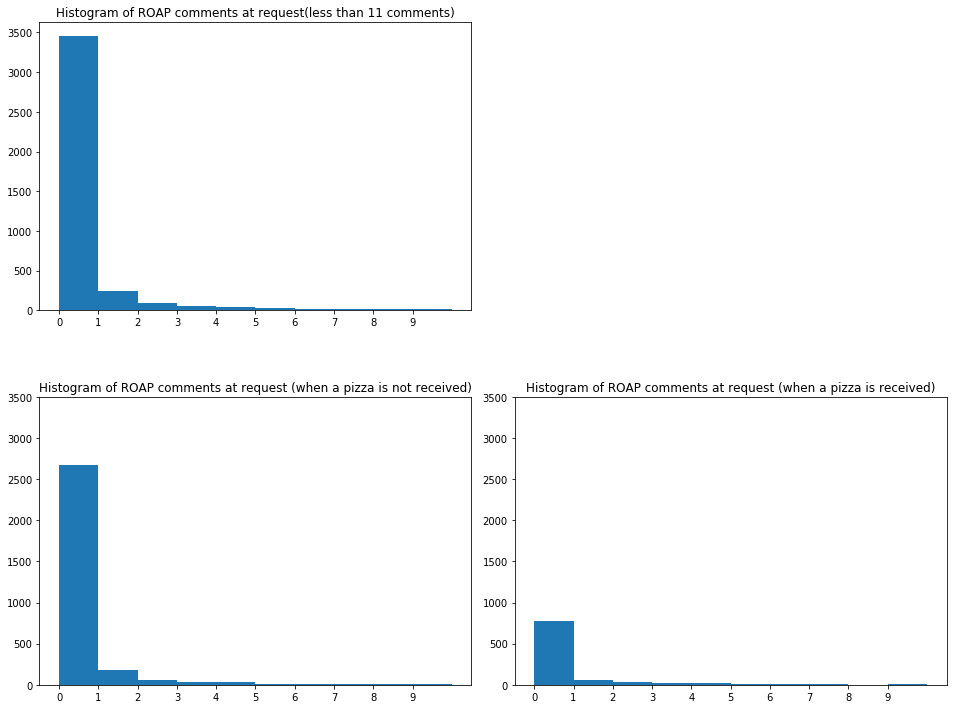

In [236]:
# plotting distribution of ROAP comments
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.requester_number_of_comments_in_raop_at_request[train_df.requester_number_of_comments_in_raop_at_request <11])
axes1.set_title("Histogram of ROAP comments at request(less than 11 comments)")
axes1.set_yticks(range(0,4000, 500))
axes1.set_xticks(range(0,10, 1))

# plotting distribution of ROAP comments when someone received a pizza
axes2.hist(train_df.requester_number_of_comments_in_raop_at_request[(train_df.requester_received_pizza == 1) & (train_df.requester_number_of_comments_in_raop_at_request <11)])
axes2.set_title("Histogram of ROAP comments at request (when a pizza is received)")
axes2.set_yticks(range(0,4000, 500))
axes2.set_xticks(range(0,10, 1))

# plotting distribution of ROAP comments when someone did not receive a pizza
axes3.hist(train_df.requester_number_of_comments_in_raop_at_request[(train_df.requester_received_pizza == 0) & (train_df.requester_number_of_comments_in_raop_at_request <11)])
axes3.set_title("Histogram of ROAP comments at request (when a pizza is not received)")
axes3.set_yticks(range(0,4000, 500))
axes3.set_xticks(range(0,10, 1))

In [201]:
# now using buckets ROAP comments
train_df['roap_comments_start_bucketed'] = np.where(train_df.requester_number_of_comments_in_raop_at_request >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.roap_comments_start_bucketed)


roap_comments_start_bucketed,0,1
requester_received_pizza,,
False,2674,372
True,779,215


In [248]:
(779+215)

994

In [186]:
# seeing number of requestors by whether they got a pizza and number of ROAP comments
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.requester_number_of_comments_in_raop_at_request, 90)) 

requester_number_of_comments_in_raop_at_request,"(-0.088, 0.978]","(0.978, 1.956]","(1.956, 2.933]","(2.933, 3.911]","(3.911, 4.889]","(4.889, 5.867]","(5.867, 6.844]","(6.844, 7.822]","(7.822, 8.8]","(8.8, 9.778]",...,"(28.356, 29.333]","(32.267, 33.244]","(39.111, 40.089]","(42.044, 43.022]","(46.933, 47.911]","(51.822, 52.8]","(53.778, 54.756]","(55.733, 56.711]","(76.267, 77.244]","(87.022, 88.0]"
requester_received_pizza,,,,,,,,,,,,,,,,,,,,,
False,2674,176,63,38,30,14,10,8,13,3,...,1,0,1,0,0,1,0,0,0,0
True,779,64,35,23,19,12,7,5,3,6,...,2,1,1,1,1,0,1,1,1,1


## requester_number_of_comments_in_raop_at_retrieval
Total number of comments in RAOP by requester at time of retrieval.

Notes: 
The range is 0 to 139 comments. About 1712 requestors have 0 comments after posting in ROAP. This means that about 2,000 requestors had 0 ROAP comments at the beginning, ended up commenting, and got pushed out of the 0 ROAP comment bucket at the end of their request. This could be people that got a pizza and thanked someone or needed to provide follow up information.

About 10% of those with 0 comments remaining end up getting a pizza. While, 56% of those who have >0 comments end up getting a pizza.


In [208]:
print(train_df.requester_number_of_comments_in_raop_at_retrieval.describe())
# print(train_df.requester_number_of_comments_in_raop_at_retrieval.value_counts())
print(train_df.requester_number_of_comments_in_raop_at_retrieval.value_counts()[:5])
print(train_df.requester_number_of_comments_in_raop_at_retrieval.value_counts()[-5:])


count    4040.000000
mean        2.626733
std         6.480189
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       139.000000
Name: requester_number_of_comments_in_raop_at_retrieval, dtype: float64
0    1712
1     749
2     460
3     284
4     210
Name: requester_number_of_comments_in_raop_at_retrieval, dtype: int64
110    1
62     1
56     1
52     1
139    1
Name: requester_number_of_comments_in_raop_at_retrieval, dtype: int64


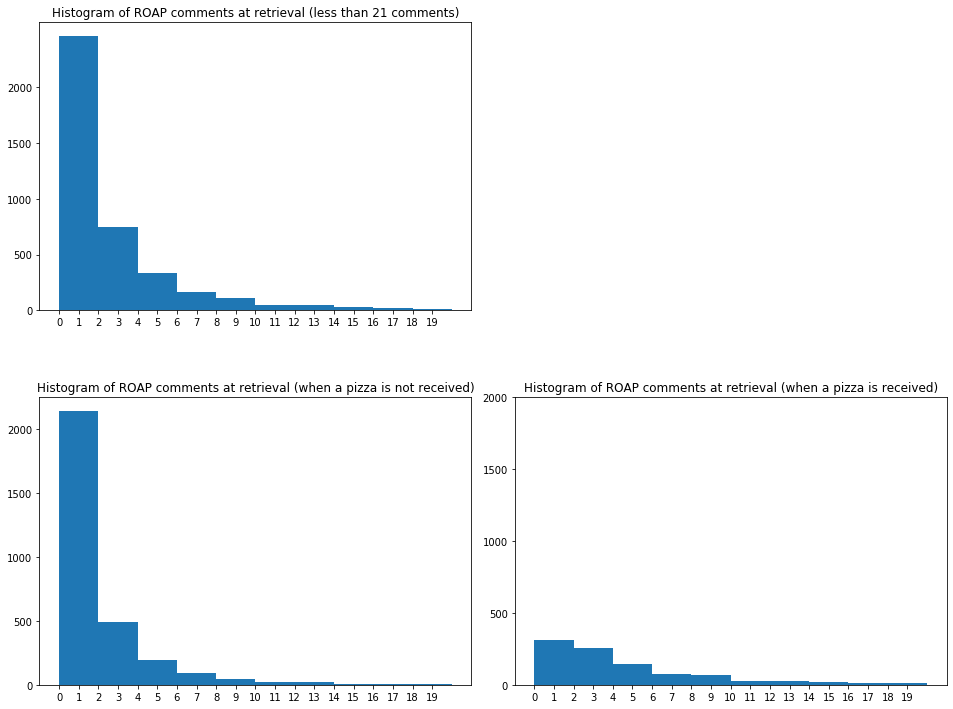

In [242]:
# plotting distribution of ROAP comments
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.requester_number_of_comments_in_raop_at_retrieval[train_df.requester_number_of_comments_in_raop_at_retrieval <21])
axes1.set_title("Histogram of ROAP comments at retrieval (less than 21 comments)")
axes1.set_yticks(range(0,2500, 500))
axes1.set_xticks(range(0,20, 1))

# plotting distribution of ROAP comments when someone received a pizza
axes2.hist(train_df.requester_number_of_comments_in_raop_at_retrieval[(train_df.requester_received_pizza == 1) & (train_df.requester_number_of_comments_in_raop_at_retrieval <21)])
axes2.set_title("Histogram of ROAP comments at retrieval (when a pizza is received)")
axes2.set_yticks(range(0,2500, 500))
axes2.set_xticks(range(0,20, 1))

# plotting distribution of ROAP comments when someone did not receive a pizza
axes3.hist(train_df.requester_number_of_comments_in_raop_at_retrieval[(train_df.requester_received_pizza == 0) & (train_df.requester_number_of_comments_in_raop_at_retrieval <21)])
axes3.set_title("Histogram of ROAP comments at retrieval (when a pizza is not received)")
axes3.set_yticks(range(0,2500, 500))
axes3.set_xticks(range(0,20, 1))

In [202]:
# now using buckets ROAP comments
train_df['roap_comments_end_bucketed'] = np.where(train_df.requester_number_of_comments_in_raop_at_retrieval >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.roap_comments_end_bucketed)


roap_comments_end_bucketed,0,1
requester_received_pizza,,
False,1549,1497
True,163,831


In [207]:
# seeing number of requestors by whether they got a pizza and number of ROAP comments
# 2 to 18 comments seems like a good likelihood
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.requester_number_of_comments_in_raop_at_retrieval, 70)) 

requester_number_of_comments_in_raop_at_retrieval,"(-0.139, 1.986]","(1.986, 3.971]","(3.971, 5.957]","(5.957, 7.943]","(7.943, 9.929]","(9.929, 11.914]","(11.914, 13.9]","(13.9, 15.886]","(15.886, 17.871]","(17.871, 19.857]",...,"(49.643, 51.629]","(51.629, 53.614]","(53.614, 55.6]","(55.6, 57.586]","(61.557, 63.543]","(91.343, 93.329]","(109.214, 111.2]","(113.186, 115.171]","(115.171, 117.157]","(137.014, 139.0]"
requester_received_pizza,,,,,,,,,,,,,,,,,,,,,
False,2148,491,191,89,48,21,20,10,5,2,...,0,1,0,1,0,0,0,0,0,0
True,313,253,147,75,67,26,25,18,13,9,...,1,1,1,0,2,2,1,1,1,1


## requester_number_of_posts_at_request
Total number of posts on Reddit by requester at time of request.

Notes:
The range is 0 to 867 Reddit post. About 1198 requestors have 0 post on Reddit. Half of the requesters have 5 or less Reddit posts. Since the mean is so high (esp compared to the median) there must be outliers which are people who are very very active Reddit posters. 

24% of those with 0 Reddit posts got a pizza. 37% of those who have >0 Reddit posts got a pizza.


In [209]:
print(train_df.requester_number_of_posts_at_request.describe())
# print(train_df.requester_number_of_posts_at_request.value_counts())
print(train_df.requester_number_of_posts_at_request.value_counts()[:5])
print(train_df.requester_number_of_posts_at_request.value_counts()[-5:])

count    4040.000000
mean       21.601485
std        50.895060
min         0.000000
25%         0.000000
50%         5.000000
75%        22.000000
max       867.000000
Name: requester_number_of_posts_at_request, dtype: float64
0    1198
1     293
2     218
3     167
4     131
Name: requester_number_of_posts_at_request, dtype: int64
586    1
594    1
809    1
824    1
612    1
Name: requester_number_of_posts_at_request, dtype: int64


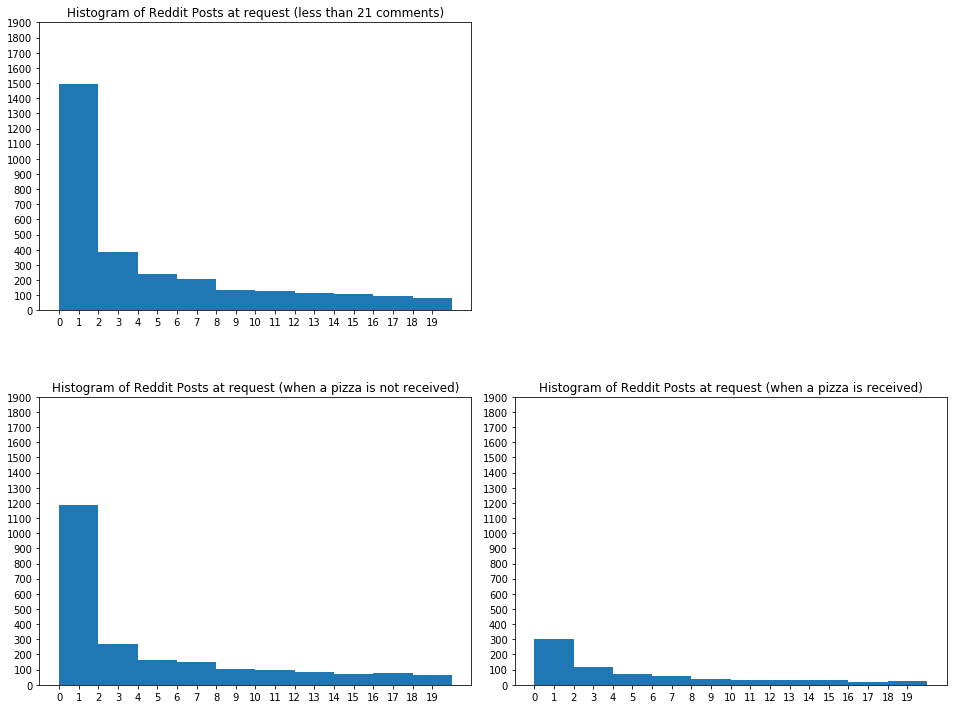

In [228]:
# plotting distribution of Reddit Posts
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.requester_number_of_posts_at_request[train_df.requester_number_of_posts_at_request <21])
axes1.set_title("Histogram of Reddit Posts at request (less than 21 comments)")
axes1.set_yticks(range(0,2000, 100))
axes1.set_xticks(range(0,20, 1))

# plotting distribution of Reddit Posts when someone received a pizza
axes2.hist(train_df.requester_number_of_posts_at_request[(train_df.requester_received_pizza == 1) & (train_df.requester_number_of_posts_at_request <21)])
axes2.set_title("Histogram of Reddit Posts at request (when a pizza is received)")
axes2.set_yticks(range(0,2000, 100))
axes2.set_xticks(range(0,20, 1))

# plotting distribution of Reddit Posts when someone did not receive a pizza
axes3.hist(train_df.requester_number_of_posts_at_request[(train_df.requester_received_pizza == 0) & (train_df.requester_number_of_posts_at_request <21)])
axes3.set_title("Histogram of Reddit Posts at request (when a pizza is not received)")
axes3.set_yticks(range(0,2000, 100))
axes3.set_xticks(range(0,20,1))

In [213]:
# now using buckets Reddit posts start
train_df['reddit_posts_start_bucketed'] = np.where(train_df.requester_number_of_posts_at_request >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.reddit_posts_start_bucketed)


reddit_posts_start_bucketed,0,1
requester_received_pizza,,
False,967,2079
True,231,763


In [223]:
# seeing number of requestors by whether they got a pizza and number of Reddit posts at start
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.requester_number_of_posts_at_request, 20)) 


requester_number_of_posts_at_request,"(-0.867, 43.35]","(43.35, 86.7]","(86.7, 130.05]","(130.05, 173.4]","(173.4, 216.75]","(216.75, 260.1]","(260.1, 303.45]","(303.45, 346.8]","(346.8, 390.15]","(390.15, 433.5]","(433.5, 476.85]","(476.85, 520.2]","(563.55, 606.9]","(606.9, 650.25]","(780.3, 823.65]","(823.65, 867.0]"
requester_received_pizza,,,,,,,,,,,,,,,,
False,2639,238,75,47,17,9,6,1,6,1,1,2,1,0,1,2
True,838,98,27,11,5,8,0,3,1,0,0,0,1,2,0,0


## requester_number_of_posts_at_retrieval
Total number of posts on Reddit by requester at time of retrieval.

Notes:
The range is 0 to 999 Reddit posts. About 843 requestors have 0 posts on Reddit (less than when they first started). Half of the requesters have 13 or less Reddit posts (more than when they first started). Just like Reddit posts at the start, the mean is high so there must be outliers which represent people who are very very active Reddit posters.

24% of those with 0 Reddit posts got a pizza. 37% of those who have >0 Reddit posts got a pizza.


In [224]:
print(train_df.requester_number_of_posts_at_retrieval.describe())
# print(train_df.requester_number_of_posts_at_retrieval.value_counts())
print(train_df.requester_number_of_posts_at_retrieval.value_counts()[:5])
print(train_df.requester_number_of_posts_at_retrieval.value_counts()[-5:])

count    4040.000000
mean       41.151733
std        80.798543
min         0.000000
25%         2.000000
50%        13.000000
75%        46.000000
max       999.000000
Name: requester_number_of_posts_at_retrieval, dtype: float64
1    843
2    271
3    174
4    131
5     91
Name: requester_number_of_posts_at_retrieval, dtype: int64
482    1
164    1
432    1
412    1
999    1
Name: requester_number_of_posts_at_retrieval, dtype: int64


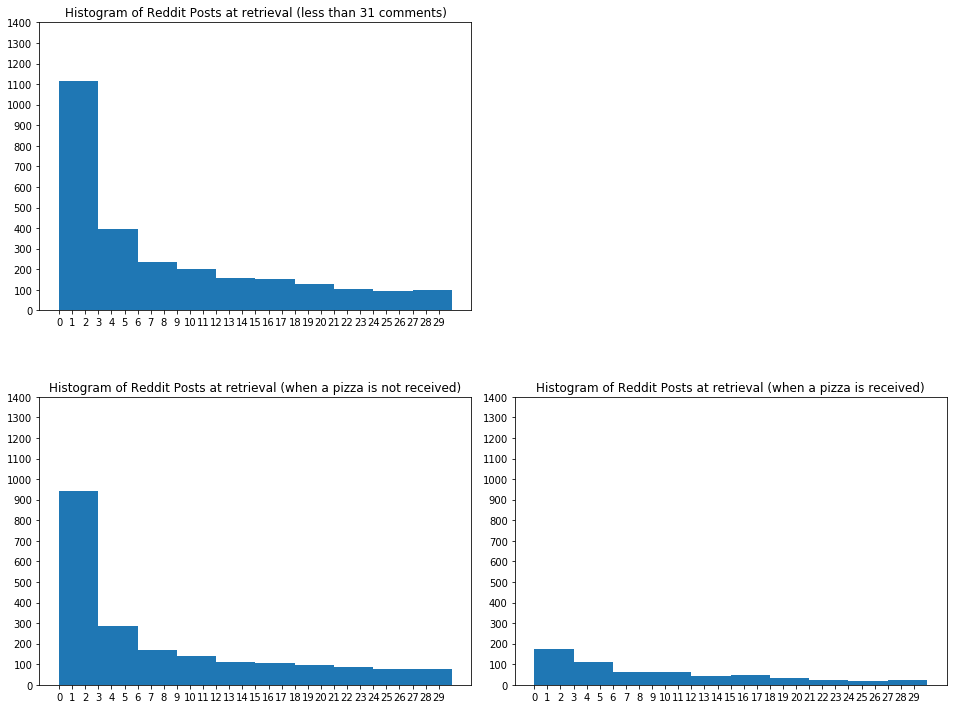

In [227]:
# plotting distribution of Reddit Posts
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.requester_number_of_posts_at_retrieval[train_df.requester_number_of_posts_at_retrieval <31])
axes1.set_title("Histogram of Reddit Posts at retrieval (less than 31 comments)")
axes1.set_yticks(range(0,1500, 100))
axes1.set_xticks(range(0,30, 1))

# plotting distribution of Reddit Posts when someone received a pizza
axes2.hist(train_df.requester_number_of_posts_at_retrieval[(train_df.requester_received_pizza == 1) & (train_df.requester_number_of_posts_at_retrieval <31)])
axes2.set_title("Histogram of Reddit Posts at retrieval (when a pizza is received)")
axes2.set_yticks(range(0,1500, 100))
axes2.set_xticks(range(0,30, 1))

# plotting distribution of Reddit Posts when someone did not receive a pizza
axes3.hist(train_df.requester_number_of_posts_at_retrieval[(train_df.requester_received_pizza == 0) & (train_df.requester_number_of_posts_at_retrieval <31)])
axes3.set_title("Histogram of Reddit Posts at retrieval (when a pizza is not received)")
axes3.set_yticks(range(0,1500, 100))
axes3.set_xticks(range(0,30,1))

In [229]:
# now using buckets Reddit posts end
train_df['reddit_posts_end_bucketed'] = np.where(train_df.requester_number_of_posts_at_retrieval >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.reddit_posts_end_bucketed)


reddit_posts_end_bucketed,0,1
requester_received_pizza,,
False,2,3044
True,1,993


In [230]:
# seeing number of requestors by whether they got a pizza and number of Reddit posts at end
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.requester_number_of_posts_at_retrieval, 20)) 


requester_number_of_posts_at_retrieval,"(-0.999, 49.95]","(49.95, 99.9]","(99.9, 149.85]","(149.85, 199.8]","(199.8, 249.75]","(249.75, 299.7]","(299.7, 349.65]","(349.65, 399.6]","(399.6, 449.55]","(449.55, 499.5]","(499.5, 549.45]","(549.45, 599.4]","(599.4, 649.35]","(649.35, 699.3]","(799.2, 849.15]","(849.15, 899.1]","(899.1, 949.05]","(949.05, 999.0]"
requester_received_pizza,,,,,,,,,,,,,,,,,,
False,2371,347,155,66,39,21,17,6,4,6,3,2,2,1,0,2,1,3
True,724,145,53,26,18,7,7,5,0,2,1,1,0,1,1,1,1,1
